# Plots


---


**This is a script to plot the comnfusion matrixes and Roc curves for every model and every window size presented in this work.** 

under this section you can find all the global variables, imports and settings.

The installation of `!pip install pretty-confusion-matrix` can be found as well.


---


**NOTE !**

For the script to work some changes should be applied to the pretty-confusion-matrix installed model. 

After installing the pip reposetory restart, apply the changes and then restart the runtime agian. 


**The changes are -**

At first i removed a couple of lines which prevented me from changing the figure and font size.
*   Lint 275 i removed `fz = 11`
*   Lint 276 i removed `figsize = [9, 9]`

Then added some costumeztions so the puction will suite me better and save the figure insted of just ploting it.

*   Line 144 added variable `modelnum` to function decleration of `def pp_matrix(...)`
*   Line 281 where added variable `modelnum`
*   Line 242 change the path relevent to you `plt.savefig('/content/drive/MyDrive/BioKey/Plots/CM model '+modelnum+'.png',dpi = 150)`


In pretty-confusion-matrix.py you shuld copy and paste [this file](https://drive.google.com/file/d/10NFOAcqjaIfbj0DaojIQHXqNU6nmXrim/view?usp=sharing). Where all my changes are allready updated. 



In [ ]:
%tensorflow_version 2.x
from sklearn.model_selection import validation_curve
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import ast
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import h5py
import sklearn.metrics as metrics

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 18})

In [ ]:
train_data = np.array([])
train_labels = np.array([])
val0_data = np.array([])
val0_labels = np.array([])
val1_data = np.array([])
val1_labels = np.array([])
test_y = np.array([])
test_x = np.array([])

In [ ]:
!pip install pretty-confusion-matrix
from pretty_confusion_matrix import pp_matrix_from_data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 10.2 MB/s 
     |████████████████████████████████| 73 kB 1.8 MB/s 
     |████████████████████████████████| 103 kB 61.5 MB/s 
     |████████████████████████████████| 11.2 MB 46.3 MB/s 
     |████████████████████████████████| 156 kB 50.1 MB/s 
     |████████████████████████████████| 843 kB 33.0 MB/s 
     |████████████████████████████████| 68 kB 4.2 MB/s 
     |████████████████████████████████| 41 kB 596 kB/s 
     |████████████████████████████████| 930 kB 38.5 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
     |████████████████████████████████| 98 kB 9.5 MB/s 
     |████████████████████████████████| 8.8 MB 52.4 MB/s 
     |████████████████████████████████| 461 kB 71.8 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Atte

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# loadData


---


`def loadData(dir,ws):`

***Description:*** Load the data from a given directory and aplies Sliding window over it with the given size ws.

***Input:*** String `dir` is a directory, int `WS` window size.

***Output:*** no returns, load in to the global variables the data from the h5 file.

***Algorithm:*** first we load the rain data from the given h5 file. then we take the first 1000 tupels to be the testing data. for lable 0 and 1 to `val0` and `val1` respectivly.
Then we reshape the data to an array of window where every window is of size ws given to the function.
and we save all the first 1000 in the test variables, bothe data and lables. 

In [ ]:
def loadData(dir,ws):
  global val0_data
  global val0_labels
  global val1_data
  global val1_labels
  global test_y
  global test_x
  global train_data
  global train_labels

  #Setting the variables
  train_data = np.array([])
  train_labels = np.array([])
  val0_data = np.array([])
  val0_labels = np.array([])
  val1_data = np.array([])
  val1_labels = np.array([])
  test_y = np.array([])
  test_x = np.array([])

  #Load file
  with h5py.File(dir,'r') as hdf:
    data = hdf.get('train_data')
    train_data = np.array(data)
    data = hdf.get('train_labels')
    train_labels = np.array(data)

  #get the data of labale 0
  for i in range(1000):
    if train_labels[i] == 0:
      val0_data = np.append(val0_data,train_data[i])
  #create a lables in the amount of data 
  val0_labels = np.empty(int(val0_data.shape[0]/(ws*6)))
  val0_labels.fill(0)

  #get the data of labale 1
  for i in range(1000):
    if train_labels[i] == 1:
      val1_data = np.append(val1_data,train_data[i])
  #create a lables in the amount of data 
  val1_labels = np.empty(int(val1_data.shape[0]/(ws*6)))
  val1_labels.fill(1)

  #Reshape the data to an array of windows of size ws
  val1_data = val1_data.reshape(int(val1_labels.shape[0]),ws,6)
  val0_data = val0_data.reshape(int(val0_labels.shape[0]),ws,6)

  #save test data
  test_x = train_data[:1000]
  test_y = train_labels[:1000]

  #remove test data from the whole data
  train_data = train_data[1000:]
  train_labels = train_labels[1000:]

# plotRoc


---


`def plotRoc(model,test_x,test_y,fname):`

***Description:*** Plots a ROC curve and a zoomed version between (0.8, 1) on the y axis.

***Input:*** 

`model` - a loaded and tranied model

`test_x` - the test data

`test_y` - the test lables

`fname` - the name of the model.

***Output:*** no returns, plots and save the ploted figuers in to a directory as a .png file.

***Algorithm:*** Given a trained `model` it runs a prediction on the test data `test_x` and using a argmax function takes only the higher prediction. then using `roc_curv` function to get the tpr and fpr. using the fpr, tpr and the `metrics.auc` function to get a ROC curv. thenwe set the plot bounderis and the plots lables and save the plot. 

the same gos for the zoomed plot version where we already have the model's ROC, tpr and fpr so the only part that we have here is setting bounderis and labales.


In [ ]:
def plotRoc(model,test_x,test_y,fname):
  from sklearn.metrics import roc_curve
  import sklearn.metrics as metrics
  y_pred_keras = model.predict(test_x).ravel()
  y_pred_keras = y_pred_keras.reshape(1000,2)
  y_pred_keras = np.argmax(y_pred_keras, axis=-1)
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, y_pred_keras)
  roc_auc = metrics.auc(fpr_keras, tpr_keras)

  #Set title
  plt.title('ROC')
  plt.plot(fpr_keras, tpr_keras, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  #Set bounderis
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  #Set lables
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  #save figuer
  plt.savefig('/content/drive/MyDrive/BioKey/Plots/Roc model '+fname+'.png',dpi = 150)
  #Plot zoomed
  plt.plot([0, 1], [0, 1], 'k--')
  #Set title
  plt.title('ROC')
  plt.plot(fpr_keras, tpr_keras, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  #Set bounderis
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim(0, 0.2)
  plt.ylim(0.8, 1)
  #Set lables
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  #save figuer
  plt.savefig('/content/drive/MyDrive/BioKey/Plots/zoom Roc model '+fname+'.png',dpi = 150)

  return fpr_keras,tpr_keras,y_pred_keras
  

# plotMultipleRoclst


---


`def plotMultipleRoclst(fprlst,tprlst,hdfin,model_name):`

***Description:*** Plots a ROC curve and a zoomed version between (0.8, 1) on the y axis of multipul models. 

***Input:*** 

`fprlst` - a list of lists where every list represent the fpr of a diffrent model

`tprlst` - a list of lists where every list represent the tpr of a diffrent model

`hdfin` - the window size of the loaded hdf file

`model_name` - the name of the model.

***Output:*** no returns, plots and save the ploted figuers in to a directory as a .png file.

***Algorithm:*** Given a `tprlst` and a `fprlst` list it uses the `metrics.auc` function to get a ROC curv of the i_th model and plot it. this goes for evey entry in the fpr and tpr list, in other words for every model prediction. also it gives every curve the corisponding i_th model name. then we set the plot bounderis and the plots lables and save the plot. 

the same gos for the zoomed plot version where we already have the model's ROC, tpr and fpr so the only part that we have here is setting bounderis and labales.


In [ ]:
def plotMultipleRoclst(fprlst,tprlst,hdfin,model_name):
  #Clear plot 
  plt.clf()
  #Set title
  plt.title('ROC Comperison' + str(hdfin))
  #plot the curv of every model
  for i,a in enumerate(fprlst):
    roc_auc = metrics.auc(fprlst[i], tprlst[i])
    plt.plot(fprlst[i], tprlst[i], label = model_name[i] + ', AUC = %0.2f' % roc_auc)
  #Set bounderis
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  #Set lables
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  #Save figure
  plt.savefig('/content/drive/MyDrive/BioKey/Plots/RocCom '+str(hdfin)+'.png',dpi = 150)

  #Plot zoomed
  plt.clf()
  #Clear plot 
  plt.plot([0, 1], [0, 1], 'k--')
  #Set title
  plt.title('Zoom ROC Comperison'+ str(hdfin))
  #plot the curv of every model
  for i,a in enumerate(fprlst):
    roc_auc = metrics.auc(fprlst[i], tprlst[i])
    plt.plot(fprlst[i], tprlst[i], label = model_name [i]+', AUC = %0.2f' % roc_auc)
  #Set bounderis
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim(0, 0.2)
  plt.ylim(0.8, 1)
  #Set lables
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  #Save figure
  plt.savefig('/content/drive/MyDrive/BioKey/Plots/ZommRocCom '+str(hdfin)+'.png',dpi = 150)

# danModelLoadRoc


---


`def danModelLoadRoc():`

***Description:*** Plots a ROC curve and a zoomed version between (0.8, 1) on the y axis of The dan model models. 

***Input:*** 
Gets no input but uses the following global variables - 

`fprlst` - a list of lists where every list represent the fpr of a diffrent model

`tprlst` - a list of lists where every list represent the tpr of a diffrent model

`model_name` - the name of the model.

***Output:*** no returns, plots and save the ploted figuers in to a directory as a .png file. and adds the model fpr anf tpr to the list of the models with the same window size, and the name as well. 

***Algorithm:*** Given a `tprlst` and a `fprlst` list it uses the `metrics.auc` function to get a ROC curv of the i_th model and plot it. this goes for evey entry in the fpr and tpr list, in other words for every model prediction. also it gives every curve the corisponding i_th model name. then we set the plot bounderis and the plots lables and save the plot. 

the same gos for the zoomed plot version where we already have the model's ROC, tpr and fpr so the only part that we have here is setting bounderis and labales.


In [ ]:
def danModelLoadRoc():
  loadData('/content/drive/MyDrive/BioKey/Testing system/Rand_Dan_WS30.h5',30)
  filename = "Dan_1D_2XLSTM32_150Epo_WS30.h5"
  model2 = keras.models.load_model('/content/drive/MyDrive/BioKey/Testing system/1D_2XLSTM32_1x1_Dan_150epochs_WS30.h5')
  plt.clf()
  #Plot individual ROC for the model
  fpr_keras,tpr_keras, preds = plotRoc(model2,test_x,test_y,filename[:len(filename)-3])
  #Collect the data of the fpr and tpr for the specific window size for all models 
  #with the same window size, and save model name. 
  fprlst.append(fpr_keras)
  tprlst.append(tpr_keras)
  model_name.append("Dan_1D_2XLSTM32")
  #ploting confusion matrix for the current model
  pp_matrix_from_data(test_y, preds,filename[:len(filename)-3],columns=('User','Imposter'),fz = 22,cmap= 'Blues')
  print(filename)
  print("F1 Score - ")
  print(f1_score(test_y, preds))
  print("MCC - ")
  print(matthews_corrcoef(test_y, preds))

# Main

In [ ]:
dir = '/content/drive/MyDrive/BioKey/Saved models'
dirhdf = '/content/drive/MyDrive/BioKey/Data_HDF_files'
fprlst = []
tprlst = []
from pretty_confusion_matrix import pp_matrix_from_data

1D_1XLSTM32_rand_40.h5
F1 Score - 
0.9699481865284973
MCC - 
0.9420242521314942
1D_2XLSTM32_rand_40.h5
F1 Score - 
0.967741935483871
MCC - 
0.9379230479812171
2LSTM32_rand_40.h5
F1 Score - 
0.9167502507522568
MCC - 
0.836792315187042
1D_1XLSTM32_rand_20.h5
F1 Score - 
0.8658922914466737
MCC - 
0.7485344856010392
1D_2XLSTM32_rand_20.h5
F1 Score - 
0.8602383531960998
MCC - 
0.7410966907132335
1D_1XLSTM32_rand_30.h5
F1 Score - 
0.9299492385786803
MCC - 
0.8622838054218694
1D_2XLSTM32_rand_30.h5
F1 Score - 
0.9428284854563691
MCC - 
0.8860008600245484
Dan_1D_2XLSTM32_150Epo_WS30.h5
F1 Score - 
0.9933598937583002
MCC - 
0.9894066604369145
1D_1XLSTM32_rand_50.h5
F1 Score - 
0.9864724245577523
MCC - 
0.9739623737000813
1D_2XLSTM32_rand_50.h5
F1 Score - 
0.9937759336099585
MCC - 
0.9880163184386349


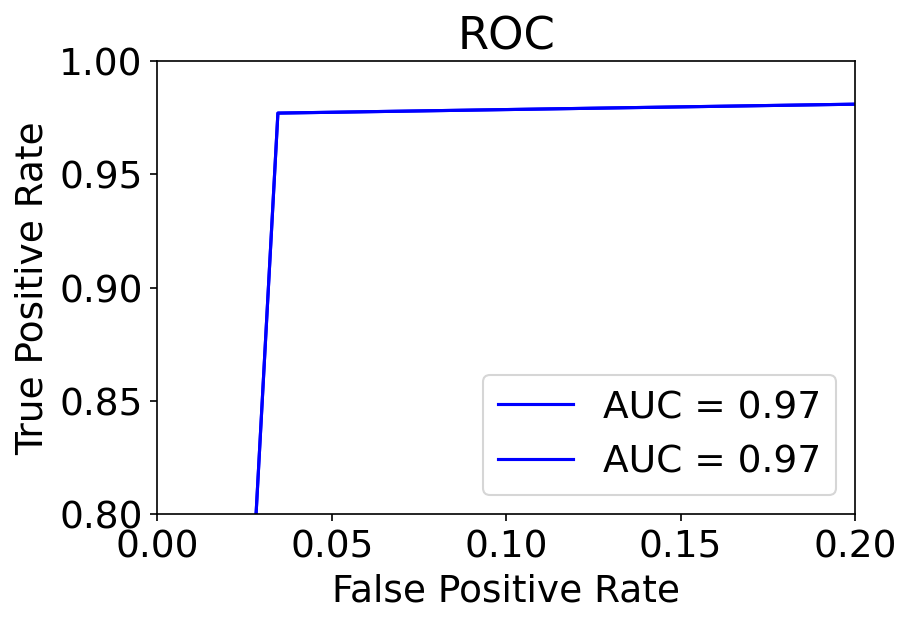

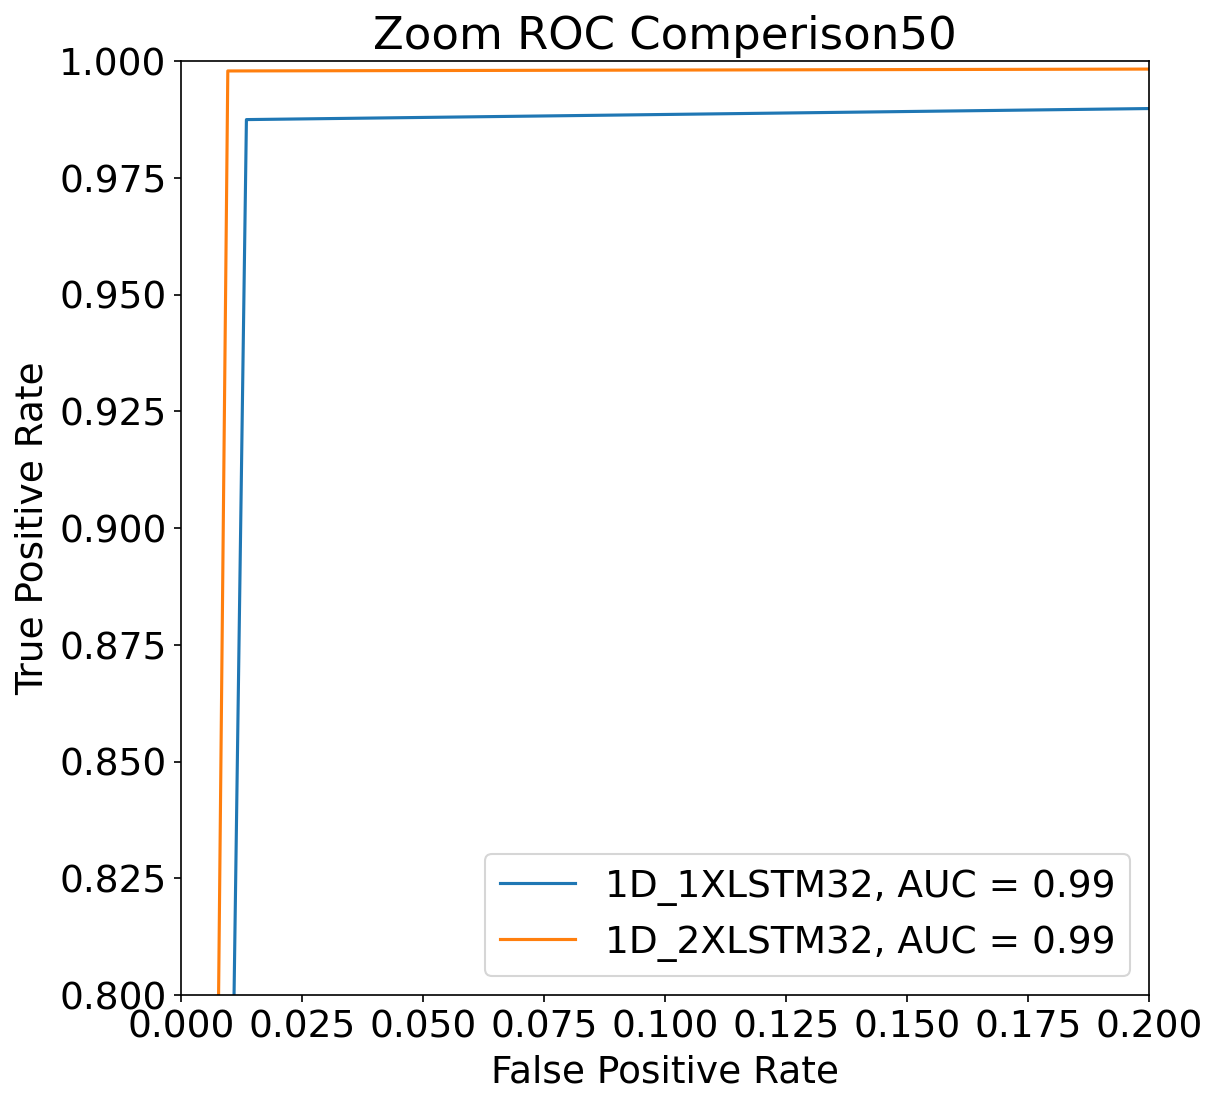

In [ ]:
#for every file in the data directory
for i,hdfilename in enumerate(os.listdir(dirhdf)):
  try:
    #Get the window size from the name. the format is xxxxxxx_rand40.h5 
    #where 40 is the window size
    hdfin = int(hdfilename[len(hdfilename)-5:len(hdfilename)-3])
  except:
    continue
  else:
    hdfilepath = os.path.join(dirhdf, hdfilename)
    loadData(hdfilepath,hdfin)
    fprlst = []
    tprlst = []
    model_name = []
    #Itrate over the saved model files directory
    for i,filename in enumerate(os.listdir(dir)):
      try:
        #Get the model window size where the format is xxxxxxx_rand40.h5
        #and 40 is the window size
        ws = int(filename[len(filename)-5:len(filename)-3])
      except:
        continue
      else:
        #Check if the model window size is the size of the loaded data file. so the 
        #input shapes will match
        if ws == hdfin: 
          filepath = os.path.join(dir, filename)
          model2 = keras.models.load_model(filepath)
          plt.clf()
          #Plot individual ROC for the model
          fpr_keras,tpr_keras, preds = plotRoc(model2,test_x,test_y,filename[:len(filename)-3])
          #Collect the data of the fpr and tpr for the specific window size for all models 
          #with the same window size, and save model name. 
          fprlst.append(fpr_keras)
          tprlst.append(tpr_keras)
          model_name.append(filename[:len(filename)- 11])
          #ploting confusion matrix for the current model
          pp_matrix_from_data(test_y, preds,filename[:len(filename)-3],columns=('User','Imposter'),fz = 22,cmap= 'Blues')
          print(filename)
          print("F1 Score - ")
          print(f1_score(test_y, preds))
          print("MCC - ")
          print(matthews_corrcoef(test_y, preds))
    #Add the dan model informaition only for window size 30 
    if hdfin == 30:
      danModelLoadRoc()
    #Plot a ROC for all models of the same window size
    plotMultipleRoclst(fprlst,tprlst,hdfin,model_name)
